# Part 1: Rogers & McClelland (2004), *Semantic Cognition: A Parallel Distributed Processing Approach*
This work was completed as a final project in *Computational Cognitive Modeling*, a graduate course in NYU's Data Science and Psychology departments, taught by Brenden Lake and Todd Gureckis.

---

What follows is an instantiation of the PDP models of semantic cognition presented in Rogers & McClelland (2004). Their models are an adaptation of an earlier model by Rumelhart (1990). From a purely theoretical perspective, these models are interesting because they show that propositional content of concepts (e.g. "Roses are red") can be learned by a model that does not store any information about the hierarchical structure of concepts. Instead, the propositional content is learned by gradual strengthening of distributed connections in a network. Beyond these theoretical implications, the models became very popular because they were able to account for a striking number of phenomena in semantic cognition, such as the gradual differentiation of conceptual knowledge during development, and the gradual degredation of it in semantic dementia.

The classic example instantiation of these models is a parallel distributed processing model that is able to learn to differentiate living things (e.g. trees, birds, flowers, fish) as well as learn the specific propositional content of each concept. Simulation 1 runs a very simple version of the model, rather like the original Rumelhart model. Simulation 2 is slightly more complicated, mostly due to increased complexities of the training set, and some small changes to the model itself. But both models make use of the same basic network structure.

I coded the models in PyTorch. PyTorch is extremely powerful and would be able to make the process of training the model much more efficient than how I implemented it here, but in order to replicate the findings of Rogers & McClelland, where they were able to show the gradual emerging dynamics of the network on each epoch, I chose slower methods (e.g. sigmoid activation functions and an MSE loss function).

In [1]:
#basics
import numpy as np
import pandas as pd
import random
import math

#pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

#visualization
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage,dendrogram
from scipy.spatial import distance_matrix

#plotting
import matplotlib.pyplot as plt
from pylab import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import display, Markdown
init_notebook_mode(connected=False)

# The model

<img src="images/Rumelhart.png" width="400">

In [2]:
class PDP(nn.Module):
    
    def __init__(self, n_items, n_outputs, n_relations, n_hidden):
        nn.Module.__init__(self)
        self.n_items = n_items
        self.hidden_size = n_hidden
        self.rep_size = n_items
        self.item2representation = nn.Linear(n_items,n_items)
        self.rr2hidden = nn.Linear(n_relations+n_items,n_hidden)
        self.hidden2attribute = nn.Linear(n_hidden,n_outputs)

    def forward(self, input):
        item = Variable(input[:self.n_items])
        relation = Variable(input[self.n_items:])
        representation = F.sigmoid(self.item2representation(item))
        combined = torch.cat((representation, relation), 0)
        hidden = F.sigmoid(self.rr2hidden(combined))
        attributes = F.sigmoid(self.hidden2attribute(hidden))
        return attributes, representation

# Simulation 1

The first simulation (presented in Chapter 3 of Rogers & McClelland, 2004) is more or less the original Rumelhart model. 

In [3]:
#read in text data
data = pd.read_csv('Rumelhart_livingthings.csv',sep=',')
data.head()

Item Relation    Attribute  TRUE
0  Pine      ISA  LivingThing     1
1  Pine      ISA        Plant     1
2  Pine      ISA         Tree     1
3  Pine      ISA         Pine     1
4  Pine       Is          Big     1

In [4]:
#convert data to a format that can be used to train a network
data_table = pd.pivot_table(data,values='TRUE',index=['Item','Relation'],columns=['Attribute'],fill_value=0).astype(float)
data_table.head()

Attribute        Animal  Bark  Big  Bird  Branches  Canary  Daisy  Feathers  \
Item   Relation                                                               
Canary Can          0.0   0.0  0.0   0.0       0.0     0.0    0.0       0.0   
       Has          0.0   0.0  0.0   0.0       0.0     0.0    0.0       1.0   
       ISA          1.0   0.0  0.0   1.0       0.0     1.0    0.0       0.0   
       Is           0.0   0.0  0.0   0.0       0.0     0.0    0.0       0.0   
Daisy  Can          0.0   0.0  0.0   0.0       0.0     0.0    0.0       0.0   

Attribute        Fish  Flower   ...    Rose  Salmon  Scales  Sing  Skin  \
Item   Relation                 ...                                       
Canary Can        0.0     0.0   ...     0.0     0.0     0.0   1.0   0.0   
       Has        0.0     0.0   ...     0.0     0.0     0.0   0.0   1.0   
       ISA        0.0     0.0   ...     0.0     0.0     0.0   0.0   0.0   
       Is         0.0     0.0   ...     0.0     0.0     0.0   0.0   0.0   
Daisy  Can        0.0     0.0   ...     0.0     0.0     0.0   0.0   0.0   

Attribute        Sunfish  Swim  Tree  Wings  Yellow  
Item   Relation                                      
Canary Can           0.0   0.0   0.0    0.0     0.0  
       Has           0.0   0.0   0.0    1.0     0.0  
       ISA           0.0   0.0   0.0    0.0     0.0  
       Is            0.0   0.0   0.0    0.0     1.0  
Daisy  Can           0.0   0.0   0.0    0.0     0.0  

[5 rows x 36 columns]

Now we can use all of this information to train the network. Input vectors correspond to every combination of categories and relations (Canary-Can, Pine-Is, etc.). Output vectors correspond to the correct activations of the property nodes given these inputs.

In [5]:
#set variables that will be used to define network architecture
living_things = sorted(data.Item.unique())
num_living_things = len(living_things)
relations = sorted(data.Relation.unique())
num_relations = len(relations)
attributes = sorted(data.Attribute.unique())
num_attributes = len(attributes)

#make inputs
input_tensor = torch.zeros([num_living_things*num_relations,num_living_things+num_relations])
item_inputs = torch.from_numpy(np.identity(num_living_things))
relation_inputs = torch.from_numpy(np.identity(num_relations))

count = 0
for ll,livingthing in enumerate(living_things):
    for rr,relation in enumerate(relations):
        input_tensor[count,:] = torch.cat([item_inputs[ll],relation_inputs[rr]],0)
        count += 1

#make outputs
output_tensor = torch.from_numpy(data_table.as_matrix())
output_tensor = Variable(output_tensor.type(torch.FloatTensor))

In [38]:
#-------------------------------------------------------------------
#TRAIN THE NETWORK AND STORE VARIABLES TO VISUALIZE NETWORK DYNAMICS
#-------------------------------------------------------------------
nepochs = 2000 #number of passes through the training set
learning_rate = 0.1 #following the original model
num_hidden_units = 15 #following the original model

#initialize the network, optimization function, and loss function
rumelhart = PDP(n_items = num_living_things, n_outputs = num_attributes, n_relations = num_relations, n_hidden = num_hidden_units) # create the network
optimizer = torch.optim.SGD(rumelhart.parameters(), lr=learning_rate) # stochastic gradient descent
criterion = nn.MSELoss() #mean squared error

error = []
reps = []
learnepoch = 0
training_patterns = [x for x in range(len(input_tensor))]
for ii in range(1,nepochs+1):
    loss = 0
    permute = np.random.permutation(training_patterns)
    for p in permute:
        rumelhart.train()
        output, representation = rumelhart.forward(input_tensor[p])
        loss += criterion(output,output_tensor[p])
        rumelhart.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    error.append(loss)
    if ii % 500 == 0: #save the representation layer every 500 training epochs
        current_reps = []
        for item_relation in input_tensor:
            out,rep = rumelhart.forward(item_relation)
            current_reps.append(rep.data.squeeze().numpy())   
        current_reps = current_reps[0:len(current_reps):num_relations]
        reps.append(current_reps)
    else: pass
    if ii == nepochs:
        print("Reached error of %s" % str(loss.data.squeeze().numpy()))
    else: pass
        
#----------------
#PLOT PERFORMANCE
#----------------
plot_error = [e.data.squeeze().numpy() for e in error]
df=pd.DataFrame(plot_error,columns=["error"])
    
trace = go.Scatter(
    x = df.index,
    y = df.error,
    mode = 'lines',
    name = 'error',
    line= go.Line()
)

layout = go.Layout(
    title = "Error",
    xaxis = dict(title="Epoch"),
    yaxis = dict(title="Error (MSE)") 
)

data = [trace]
fig = go.Figure(data = data, layout = layout)

iplot(fig, filename='layout')

Reached error of [ 0.0434665]


# Visualizing the dynamics of network learning

---

From above, it looks like the network successfully learned the concepts! The model reached a low error (<.1 MSE) by 1500-2000 sweeps through the training set on most simulations. This is great, but one of the most impressive things about the Rumelhart model is its ability to mirror the *dynamics* of category learning seen in humans - in particular, the progressive differentiation of concepts that it shows during training. 

In the original simulations, Rogers & McClelland showed this by looking at the patterns of activity in the hidden "Representation" layer (given one category as input) throughout the training process. In my training code above, I also saved the output of the Representation layer after every 500 training epochs. From this, we can look at the progressive differentiation of concepts the same way they did.

### DMs
The first way to do this is to calculate the pairwise dissimilarities between activations in the Representation layer nodes, and organizing these values into distance matrices (DMs). The DMs below show the pairwise similarities (<span style="color:blue">blue colors </span>= similarity and <span style="color:red">red colors </span>= dissimilarity).

At 500 epochs, this visualization is notable because it organizes into mostly dark blue and dark red colors - indicating the pairwise similarities are either high similarity or high dissimilarity. In particular, at this point the representational structure of the concepts in the model are organized along two broad dimensions: animal and plant. As the network learns, it becomes gradually more nuanced and differentiated - leading to, for example, a daisy being more "similar" to a sunfish than a salmon because they share the feature of being yellow.

### 500 epochs

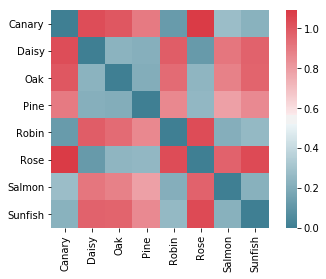

### 1000 epochs

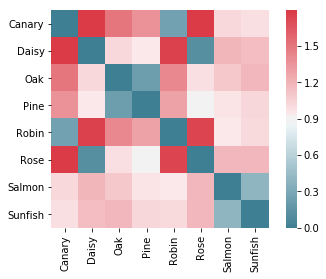

### 1500 epochs

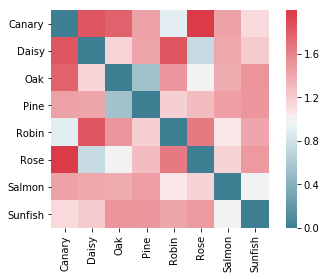

### 2000 epochs

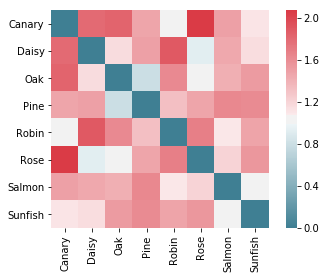

In [39]:
epochs = [i for i in range(1,nepochs+1) if i % 500 == 0]
for r in range(len(reps)):
    #plt.figure(dpi=300)
    df = pd.DataFrame(reps[r],columns=[i for i in range(len(reps[r]))],index=living_things)
    rep_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(rep_df, cmap=cmap, square = True)
    display(Markdown("### %s epochs" % epochs[r]))
    plt.show()
    plt.tight_layout()

### Hierarchical clustering

One of the ways that Rogers & McClelland reported the differentiation of their models was showing hierarchical cluster plots, which really vividly show how categories are grouped together (rather than the continuous gradient of similarity-dissimilarity shown in DMs):

<img src="images/hierarchy.png" width="400">

### 500 epochs

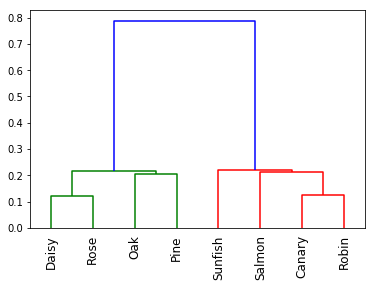

### 1000 epochs

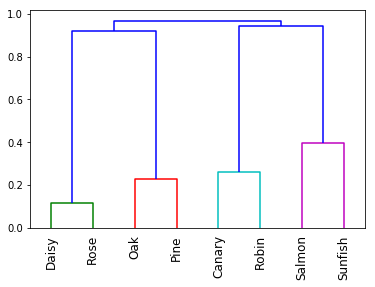

### 1500 epochs

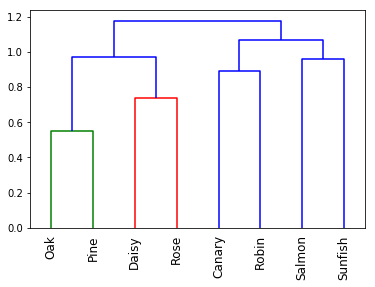

### 2000 epochs

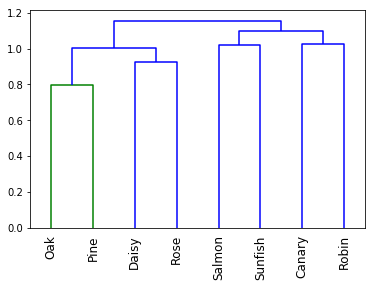

In [49]:
for r in range(len(reps)):
    #plt.figure(dpi=300)
    df = pd.DataFrame(reps[r],columns=[i for i in range(len(reps[r]))],index=living_things)
    rep_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    Z = linkage(squareform(rep_df.as_matrix()))
    dendrogram(Z,labels=living_things, leaf_rotation=90., show_contracted=True)
    display(Markdown("### %s epochs" % epochs[r]))
    plt.show()
    plt.tight_layout()

### Principal Components Analysis (PCA)

Another way of visualizing the fully trained model is to decompose the variance of the model into principal components. This is a great tool for visualization since it shows how the internal representations relate to one another in terms of distance in a low-dimensional space. Here is the PCA plot that Rogers & McClelland (2004) show for the trained Rumelhart model:

<img src="images/PCA.png" width="400">

In [50]:
pca = PCA(n_components=3)
df = pd.DataFrame(reps[-1],columns=[i for i in range(len(reps[-1]))],index=living_things)
pca.fit(df)
pca.explained_variance_ratio_

array([ 0.46792818,  0.27069792,  0.18768995])

In [42]:
reduced = pca.transform(reps[-1])
reduced = pd.DataFrame(data=reduced, index=living_things,columns=['PC1','PC2','PC3'])
reduced

PC1       PC2       PC3
Canary   1.047478  0.006043 -0.409451
Daisy   -0.694510 -0.419968 -0.447422
Oak     -0.625292  0.491309 -0.061628
Pine    -0.082024  0.882225 -0.253293
Robin    0.771186  0.299651  0.523346
Rose    -0.850017 -0.129084  0.395282
Salmon   0.150619 -0.455564  0.608563
Sunfish  0.282562 -0.674611 -0.355397

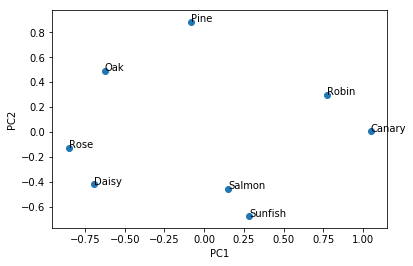

In [46]:
D1 = 0
D2 = 1

x = reduced.iloc[:,D1]
y = reduced.iloc[:,D2]
n = reduced.index

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
ax.set_xlabel('PC{}'.format(D1+1));
ax.set_ylabel('PC{}'.format(D2+1));

It seems like PC1 primarily differentiates animals vs. plants, with PC2 making within-category subdivisions (e.g. *tree* vs. *flower*). 

On most simulations, the third principal component explained a substantial amount of variance in the trained representation layer, so I plotted the items in this corresponding three-dimensional space (below). It looks like the third principal component primarily differentiates items by their color.

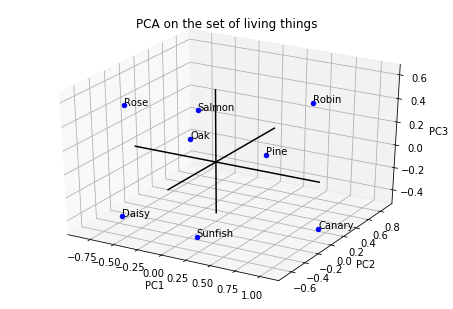

In [47]:
D1 = 0
D2 = 1
D3 = 2
x = reduced.iloc[:,D1]
y = reduced.iloc[:,D2]
z = reduced.iloc[:,D3]
n = reduced.index

fig = figure()
ax = Axes3D(fig)

for i in range(len(reduced)): #plot each point + it's index as text above
    ax.scatter(x[i],y[i],z[i],color='b') 
    ax.text(x[i],y[i],z[i], n[i],size=10, zorder=1,color='k')


# make simple, bare axis lines through space:
xAxisLine = ((min(reduced['PC1']), max(reduced['PC1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r',color='k')
yAxisLine = ((0, 0), (min(reduced['PC2']), max(reduced['PC2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r',color='k')
zAxisLine = ((0, 0), (0,0), (min(reduced['PC3']), max(reduced['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r',color='k')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the set of living things")
plt.show()


# Simulation 2: Extended training corpus
---
In Chapter 4 of Rogers & McClelland (2004), they test the generalizability of their model by providing it with a more varied training set. In particular, this training set has more than two exemplars (e.g. birch vs. pine vs. oak vs. maple, rather than pine vs. oak), and includes a wider range of animal categories, such as cats, dogs, and pigs.

One of the main advantages of the extended training set is that it allows an investigation of category typicality. For example, the "bird" category contains an atypical exemplar (penguins). It also lends a sense of ecological validity to the model since the training set is less simplified, broadly speaking.

The simulation using this training corpus will utilize the same basic network architecture, activation function, loss function, and optimization function, but with a smaller learning rate (0.01), and a larger amount of nodes per layer (with the exception of the 'Relation' layer) to accommodate the larger training set.

In [62]:
data = pd.read_csv('extended_livingthings.csv',sep=',')
data_table = pd.pivot_table(data,values='TRUE',index=['Item','Relation'],columns=['Attribute'],fill_value=0).astype(float)
data_table.head()

Attribute        Animal  Bark  Big  Birch  Bird  Branches  Canary  Cat  Cod  \
Item   Relation                                                               
Birch  Can          0.0   0.0  0.0    0.0   0.0       0.0     0.0  0.0  0.0   
       Has          0.0   1.0  0.0    0.0   0.0       1.0     0.0  0.0  0.0   
       ISA          0.0   0.0  0.0    1.0   0.0       0.0     0.0  0.0  0.0   
       Is           0.0   0.0  1.0    0.0   0.0       0.0     0.0  0.0  0.0   
Canary Can          0.0   0.0  0.0    0.0   0.0       0.0     0.0  0.0  0.0   

Attribute        Daisy   ...    Sunfish  Sunflower  Swim  Tree  Tulip  Twirly  \
Item   Relation          ...                                                    
Birch  Can         0.0   ...        0.0        0.0   0.0   0.0    0.0     0.0   
       Has         0.0   ...        0.0        0.0   0.0   0.0    0.0     0.0   
       ISA         0.0   ...        0.0        0.0   0.0   1.0    0.0     0.0   
       Is          0.0   ...        0.0        0.0   0.0   0.0    0.0     0.0   
Canary Can         0.0   ...        0.0        0.0   0.0   0.0    0.0     0.0   

Attribute        Walk  White  Wings  Yellow  
Item   Relation                              
Birch  Can        0.0    0.0    0.0     0.0  
       Has        0.0    0.0    0.0     0.0  
       ISA        0.0    0.0    0.0     0.0  
       Is         0.0    1.0    0.0     0.0  
Canary Can        0.0    0.0    0.0     0.0  

[5 rows x 53 columns]

In [63]:
#set variables that will be used to define network architecture
living_things = sorted(data.Item.unique())
num_living_things = len(living_things)
relations = sorted(data.Relation.unique())
num_relations = len(relations)
attributes = sorted(data.Attribute.unique())
num_attributes = len(attributes)

#make inputs
input_tensor = torch.zeros([num_living_things*num_relations,num_living_things+num_relations])
item_inputs = torch.from_numpy(np.identity(num_living_things))
relation_inputs = torch.from_numpy(np.identity(num_relations))

count = 0
for ll,livingthing in enumerate(living_things):
    for rr,relation in enumerate(relations):
        input_tensor[count,:] = torch.cat([item_inputs[ll],relation_inputs[rr]],0)
        count += 1

#make outputs
output_tensor = torch.from_numpy(data_table.as_matrix())
output_tensor = Variable(output_tensor.type(torch.FloatTensor))

#-------------------------------------------------------------------
#TRAIN THE NETWORK AND STORE VARIABLES TO VISUALIZE NETWORK DYNAMICS
#-------------------------------------------------------------------
nepochs = 5000 #number of passes through the training set
learning_rate = 0.01 #following the original model
num_hidden_units = 28 #following the original model

#initialize the network, optimization function, and loss function
rumelhart = PDP(n_items = num_living_things, n_outputs = num_attributes, n_relations = num_relations, n_hidden = num_hidden_units) # create the network
optimizer = torch.optim.SGD(rumelhart.parameters(), lr=learning_rate) # stochastic gradient descent
criterion = nn.MSELoss() #mean squared error
error = []
reps = []
training_patterns = [x for x in range(len(input_tensor))]
for ii in range(1,nepochs+1):
    loss = 0
    permute = np.random.permutation(training_patterns)
    for p in permute:
        rumelhart.train()
        output, representation = rumelhart.forward(input_tensor[p])
        loss += criterion(output,output_tensor[p])
        rumelhart.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    error.append(loss)
    if ii % 500 == 0: #save the representation layer every 500 training epochs
        current_reps = []
        for item_relation in input_tensor:
            out,rep = rumelhart.forward(item_relation)
            current_reps.append(rep.data.squeeze().numpy())   
        current_reps = current_reps[0:len(current_reps):num_relations]
        reps.append(current_reps)
    else: pass
    if ii == nepochs:
        print("Reached error of %s" % str(loss.data.squeeze().numpy()))
    else: pass
        
#----------------
#PLOT PERFORMANCE
#----------------
plot_error = [e.data.squeeze().numpy() for e in error]
df=pd.DataFrame(plot_error,columns=["error"])
    
trace = go.Scatter(
    x = df.index,
    y = df.error,
    mode = 'lines',
    name = 'error',
    line= go.Line()
)

layout = go.Layout(
    title = "Error",
    xaxis = dict(title="Epoch"),
    yaxis = dict(title="Error (MSE)") 
)

data = [trace]
fig = go.Figure(data = data, layout = layout)

iplot(fig, filename='layout')

Reached error of [ 0.54263991]


### 500 epochs

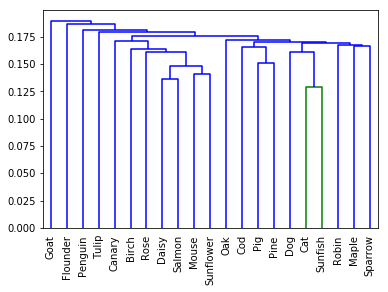

### 1000 epochs

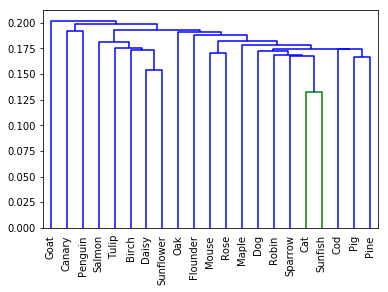

### 1500 epochs

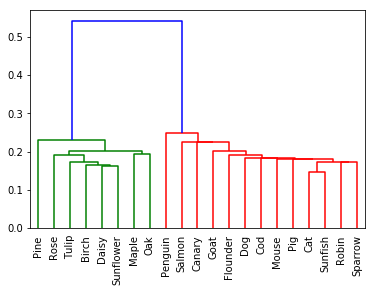

### 2000 epochs

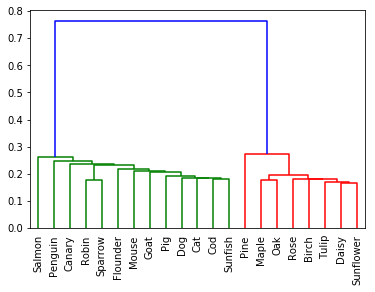

### 2500 epochs

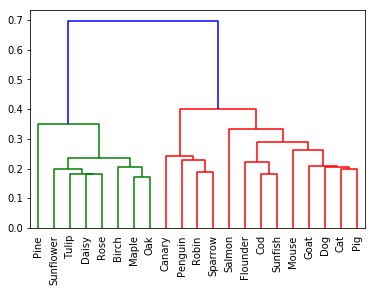

### 3000 epochs

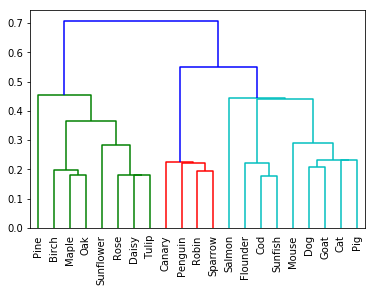

### 3500 epochs

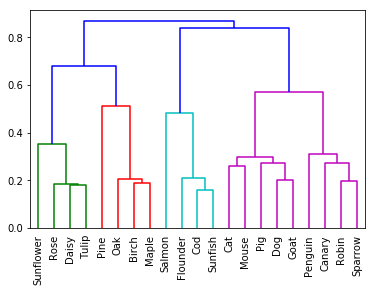

### 4000 epochs

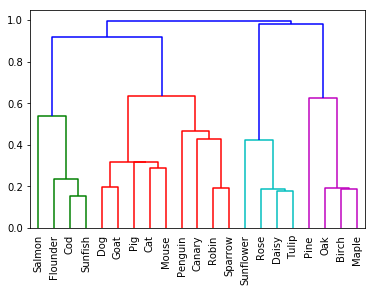

### 4500 epochs

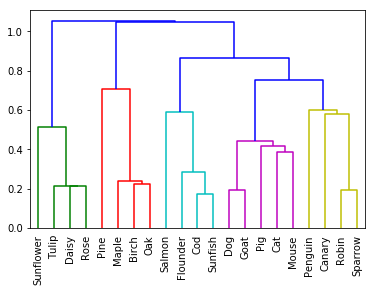

### 5000 epochs

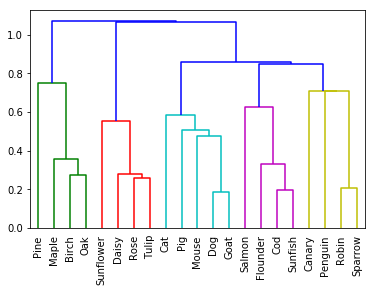

In [64]:
epochs = [i for i in range(1,nepochs+1) if i % 500 == 0]
for r in range(len(reps)):
    df = pd.DataFrame(reps[r],columns=[i for i in range(len(reps[r]))],index=living_things)
    rep_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    Z = linkage(squareform(rep_df.as_matrix()))
    dendrogram(Z,labels=living_things, leaf_rotation=90., show_contracted=True)
    display(Markdown("### %s epochs" % epochs[r]))
    plt.show()

### 500 epochs

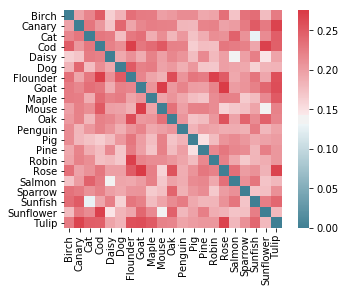

### 1000 epochs

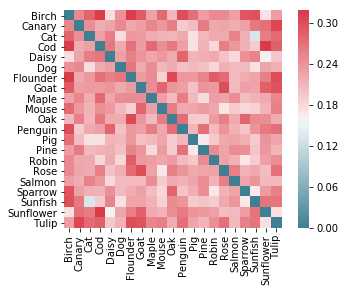

### 1500 epochs

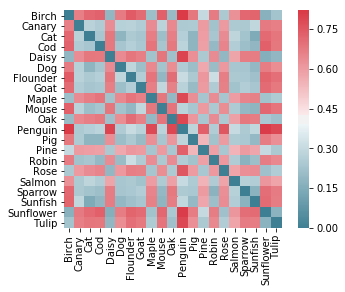

### 2000 epochs

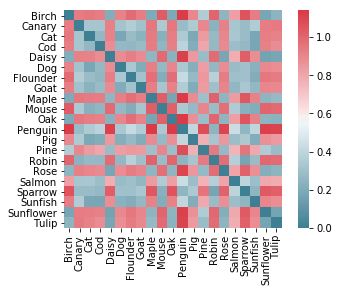

### 2500 epochs

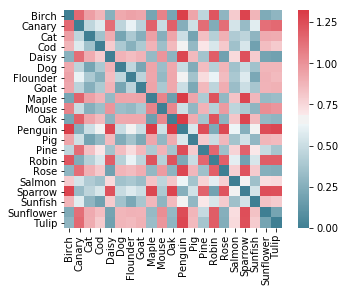

### 3000 epochs

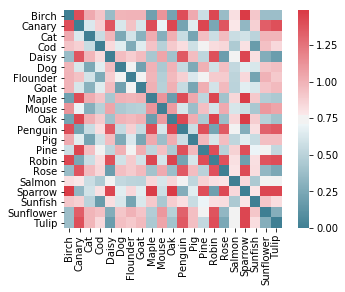

### 3500 epochs

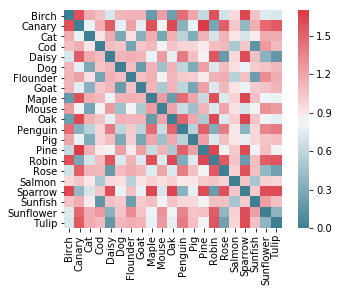

### 4000 epochs

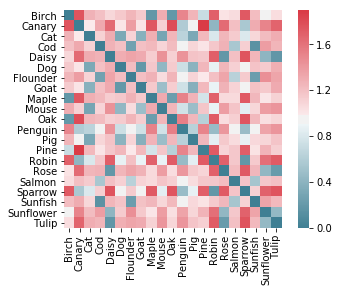

### 4500 epochs

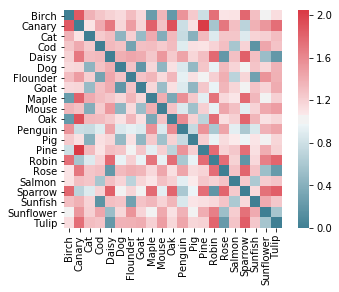

### 5000 epochs

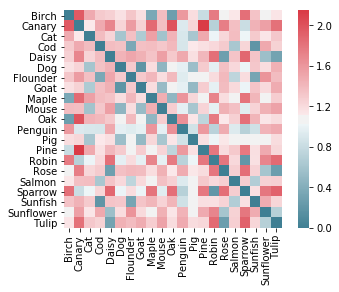

In [65]:
epochs = [i for i in range(1,nepochs+1) if i % 500 == 0]
for r in range(len(reps)):
    df = pd.DataFrame(reps[r],columns=[i for i in range(len(reps[r]))],index=living_things)
    rep_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(rep_df, cmap=cmap, square = True)
    display(Markdown("### %s epochs" % epochs[r]))
    plt.show()
    plt.tight_layout()

# References
---

McClelland, J.L., & Rogers, T.R. (2003). The parallel distributed processing approach to semantic cognition. *Nature Reviews Neuroscience*, *4*, 310-322.

Rogers, T.T., & McClelland, J.L. (2004). *Semantic Cognition: A Parallel Distributed Processing Approach*. Cambridge, MA: MIT Press.

Rumelhart, D.E. (1990). Brain style computation: Learning and generalization. In S.F. Zornetzer, J.L. Davis, & C. Lau (Eds.), *An Introduction to Neural and Electronic Networks* (pp. 405-420). San Diego, CA: Academic Press.